## Lecture 1: The Very Basics of Financial Market

We will discuss how to perform the most basic analysis of stock market.

Starting with how to process price data, we will describe the statistical properies of equity returns. We will then introduce the Sharpe Ratio as very basic measure of portfolio performance and how volatility scaling can improve the performance of a buy-and-hold strategy.

#### Price data


Price data is determined by two charactereistics, frequency of data and types of data. Frequency of data can ranged from microseconds data (tick level) to end-of-date data (daily resolution). We will focus on data that have a minute resoluion or above. Major types of data include bar data, trade data and quote data.

In an exchange, quote data (Orderbook) is displayed for a stock in real time which has the bid and ask price (with size) submitted by different market participants. Market makers are responsible for providing liquidity to different traded assets, by placing quotes continuously. A trade is made if someone is willing the buy the security at the ask price (or sell the security at the bid price). Trade data is simply a collection of all the trades of a stock made at different exchanges, along with delayed data reported from dark pools. Bar data is then aggregrated using the trade price and volume over an interval, which usually is a minute, an hour and a day.

A typical bar data would consists of 5 data fields: Open, High, Low, Close and Volume (OHLCV). For free data sources you can found online, volume data will often has the most discrepencies as off-exchange trades are often ignored/miscounted. 

The construction and processing of market data feeds invovles a lot of technical knowledge that is essential for market makers and quants reponsible for trade execution, but not too important for long-term investors. 

We will first illustrate some basic concepts in finance using the most famous ETF, SPDR S&P 500 (SPY) which keep tracks of the most important stock market index S&P 500 in the world. This ETF invest in the 500 biggest stocks listed in the US, weighted by market-cap. (The exact rules to construct S&P 500 index is more complicated than this) 

In [ ]:
! pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd

     |████████████████████████████████| 6.3 MB 7.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=828c697ef307d31d149492859c435426e20c9bc11d50b6df41078799acc21cea
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
selected_etf = yf.Ticker("SPY")
hist = selected_etf.history(period="max")

As stocks can pay dividend and have splits, we usually use adjusted price to perform statistical analysis. From the adjusted price, we can derive the total return of the stock (which is the sum of price return and dividends, reinvested). 

Always check whether dividend and splits are adjusted before running your models. 

Here I provide two examples of why data management is important and how listed companies can use that as their own advantage. 

- Example 1: Stock splits         
A stock split in theory do not change the underlying value of the company, but for retail investors looking at the price at their apps, it does look cheaper, so people buy more. Tesla has undergone stock splits more than twice in the last 5 years and stock price rises significantly after splits. 

- Example 2: Ticker name change        
GSX Techedu (GOTU) changes its ticker from GSX even without any major changes such as M&A or corporate restructuring. For retail investors, it appears as new stock for them. It also distances itself from the negative press as Muddy Waters and others are holding a short position against them.  Search engine results for GSX and GOTU are different. It seems to me like a form of Search Engine Optimisation. 
After the name change, some of the free apps that most retail traders use to keep track of stock prices cannot recognise this change and return incomplete historical data. 



In [ ]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-09-28,439.690002,440.040009,432.940002,433.720001,130436300,0.0,0
2021-09-29,435.190002,437.040009,433.850006,434.450012,82329200,0.0,0
2021-09-30,436.019989,436.769989,428.779999,429.140015,140181200,0.0,0
2021-10-01,430.980011,436.029999,427.230011,434.239990,129240100,0.0,0
2021-10-04,433.000000,433.959991,426.359985,428.640015,128430500,0.0,0


Stock price are not stationary as they tend to grow over time. (Exception: Japanese stock market). 

For building models, it is better to use the log-return instead. Log-return is better than percentage return since it is additive over different time periods. 

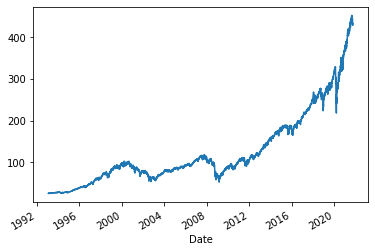

In [ ]:
hist['Close'].plot()

In [ ]:
## Calculating log-returns
hist['log_return'] = np.log(hist['Close']) - np.log(hist['Close'].shift(1))

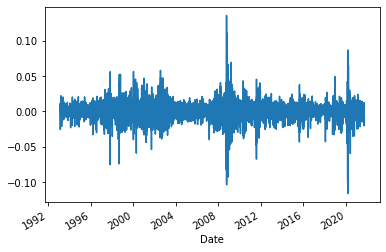

In [ ]:
hist['log_return'].plot()

#### Statistical properties of stock market log-returns 

- It has a positive mean, which is bigger than the average 10-year Treasury yield. This is called the risk premium of equity market

- It has a negative skew, which demonstrates the fact the stock market experiences sharp drawdowns over a short period (2008,2020) 

- It has a kurtosis greater than 3, suggesting it is more fat-tail than a normal distribution. 

- The assumption of log-return following Gaussian distribution(Geometric Brownian Process) is the foundation of Black-Scholes Option pricing model. 

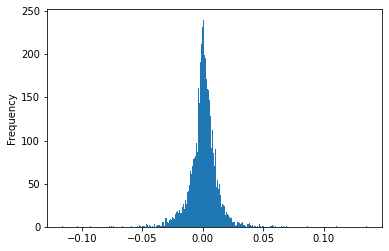

In [ ]:
hist['log_return'].plot.hist(bins=500)

In [ ]:
hist['log_return'].describe()

count    7222.000000
mean        0.000390
std         0.011825
min        -0.115886
25%        -0.004288
50%         0.000681
75%         0.005859
max         0.135578
Name: log_return, dtype: float64

In [ ]:
hist['log_return'].skew()

-0.2996344311157923

In [ ]:
hist['log_return'].kurtosis()

11.78171968286361

## How to analyse returns in stock market 

We can separate the return of stock market into two parts. One as the close-to-open return (overnight return) and open-to-close return (intraday return) 

We can see intraday return has a mean close to zero, suggesting the mean-reversion nature of stock price during market hours. 

Most of the stock market return, for a buy-and-hold strategy in the long run, comes from holding stocks overnight. This can be considered as compensation of the risk to hold stocks overnight. 

Holding stocks over the weekend and holiday will provide a similar risk premium. 


Calendar effects in stock market are often an artificat of human habits. Examples include stock return before and after the tax filing, end of month/quarter rebalancing of mutual funds, expiry of monthly and quarterly options. 


In [ ]:
hist['intraday_return'] = np.log(hist['Close']) - np.log(hist['Open'])
hist['overnight_return'] = np.log(hist['Open']) - np.log(hist['Close'].shift(1))

In [ ]:
hist['intraday_return'].describe()

count    7223.000000
mean       -0.000007
std         0.009651
min        -0.094207
25%        -0.004140
50%         0.000427
75%         0.004580
max         0.088892
Name: intraday_return, dtype: float64

In [ ]:
hist['overnight_return'].describe()

count    7222.000000
mean        0.000396
std         0.006729
min        -0.110357
25%        -0.002052
50%         0.000623
75%         0.003208
max         0.059519
Name: overnight_return, dtype: float64

## Volatility Scaling

We can measure the performance of a trading strategy by the sharpe ratio, which is ratio of excess return over to the volatility. 

Sharpe_Ratio = $\frac{r-r_f}{\sigma}$, where r is the return of the portfolio and $\sigma$ the standard deviation of the return of the portfolio. 

Volatility is detrimental to the long-term growth of capital as a strategy down 20% needs a 25% growth to recover. 

By adjusting our stock holdings so that portfolio is at a constant volatility, so that we buy more during low volatility times and buy less during high volatility times. The Sharpe ratio can be improved compared to a constant buy-and-hold strategy.

Volatility plays an important role in portfolio construction and risk management. Risk parity, a famous hedge fund strategy aims to hold constant volatility exposure to different assets in the portfolio, rather than equal weighted. 



In [ ]:
selected_etf = yf.Ticker("SPY")
hist = selected_etf.history(period="max")
hist['return'] = hist['Close'].pct_change()
hist['volatility'] = hist['return'].rolling(21).std()
hist['volatility_mean'] = hist['volatility'].rolling(21*12).mean()

In [ ]:
# Weight portfolio by comparing the current 1-month volatility with that of the most recent year 
hist['vol_adj_return'] = hist['return'] / hist['volatility'] * hist['volatility_mean']
hist['vol_port_size'] = hist['volatility_mean'] / hist['volatility']

In [ ]:
hist['return'].mean() / hist['return'].std() * np.sqrt(252)

0.038933253086714165

In [ ]:
## Improvement of Sharpe ratio of constant vol strategy 
hist['vol_adj_return'].mean() / hist['vol_adj_return'].std() * np.sqrt(252)

0.05387732991872466

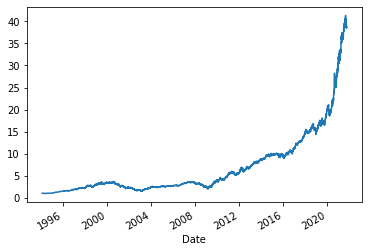

In [ ]:
(1+hist['vol_adj_return']).cumprod().plot()

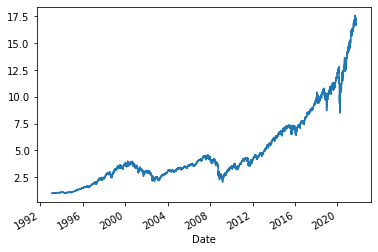

In [ ]:
(1+hist['return']).cumprod().plot()

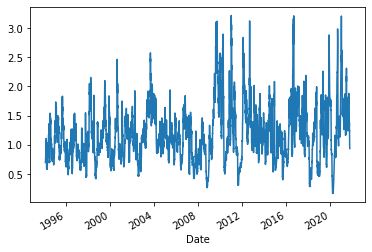

In [ ]:
hist['vol_port_size'].plot()

To carry out the above volatility adjusted strategy, you need to have access to leverage (up to 3x). 

In [ ]:
selected_etf = yf.Ticker("EEM")
hist = selected_etf.history(period="max")

In [ ]:
hist['return'] = hist['Close'].pct_change()
hist['volatility'] = hist['return'].rolling(21).std()
hist['volatility_mean'] = hist['volatility'].rolling(21*12).mean()

# Weight portfolio by comparing the current 3-month volatility with that of the most recent year 
hist['vol_adj_return'] = hist['return'] / hist['volatility'] * hist['volatility_mean']
hist['vol_port_size'] = hist['volatility_mean'] / hist['volatility']

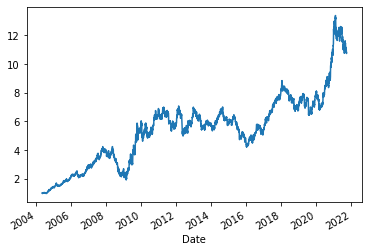

In [ ]:
(1+hist['vol_adj_return']).cumprod().plot()

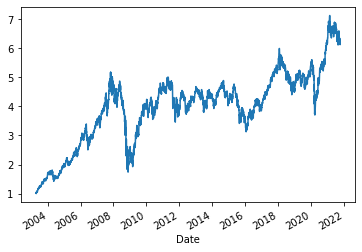

In [ ]:
(1+hist['return']).cumprod().plot()

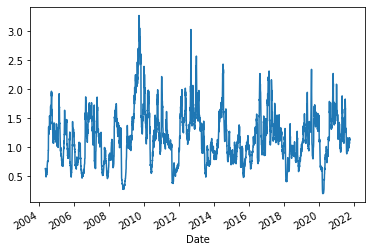

In [ ]:
hist['vol_port_size'].plot()

The above strategy also applies to EM stock market. As long as the ETF will generate positive return in the long run, volatility scaling can improve sharpe ratio and return of strategy. 


## Recommended readings 

- Algorithmic Trading: Winning Strategies and Their Rationale, Ernest P. Chan

- Advances in Financial Machine Learning, Marcos López de Prado

- A Complete Guide to the Futures Market: Technical Analysis, Trading Systems, Fundamental Analysis, Options, Spreads, and Trading Principles (Wiley Trading), Jack D. Schwager

## Lecture 2 Market Regimes and Volatility 

Volatility is undesirable since they erode long term return of the portfolio. Investors are looking for ways to reduce portfolio volatility. For asset managers, holding government bonds and derivatives(put options) are common means to hedge against equity holdings they have.

A put option can be thought as an insurance policy in a informal way. From this perspective, asset managers buy put options (in reality put spreads or other more sophiscated strategies) to reduce drawdown in portfolio during market distress. 

The benefit of reducing drawdown and thus volatility in portfolio is that it allows rebalancing after market crash. Investors can sell their bonds or gains from put options to buy cheap stocks. 

In this lecture, we will show that the buy-and-hold strategy is inherent a short volatility strategy, which means it benefits when market volatility is low/falling. 


### Fear Gauge VIX 

VIX is considered as a fear gauge of global market. 

VIX is derived from the implied volatility of front-month options of SPX index. 

It is not possible to invest in VIX directly. There are volatility ETFs which keep tracks of the VIX Futures, where traders buy and sell to express their views on market volatility. VXX is an example of volatility ETF that are widely traded by retail.  

Due to rollover costs, VXX will generate a much worse return than VIX.

A crucial feature is that holding VIX futures, and similarly buying Put Options on SPY generates a negative return in the long run.

Considering the correlation between VXX (Long volatility) and SH (Short SPY) we conclude the long volatility strategies are inherently shorting the market. 

Assuming we can short VXX (that is short volatility) without additional borrowing cost, it will have a high correlation with the market return (long SPY). This is why we call buy-and-hold equity as inherenetly a short volatility strategy. 

Since buy-and-hold VXX will simply cancels the return from holding SPY, therefore VXX alone is not a good portfolio hedge. 




In [ ]:
## VIX index, the fear gauge of the global equity market 
selected_etf = yf.Ticker("^VIX")

In [ ]:
vixhist = selected_etf.history(period="max")

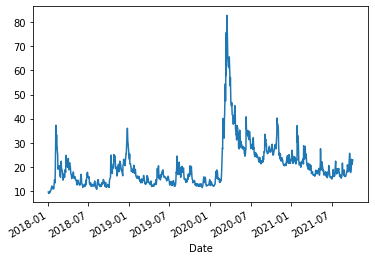

In [ ]:
vixhist['Close'].loc['2018-01-01':].plot()

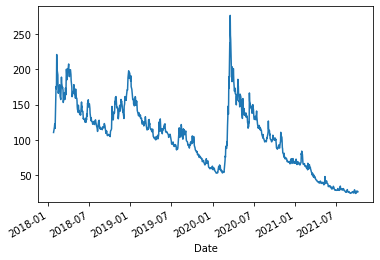

In [ ]:
selected_etf = yf.Ticker("VXX")
vxxhist = selected_etf.history(period="max")
vxxhist['Close'].loc['2018-01-01':].plot()

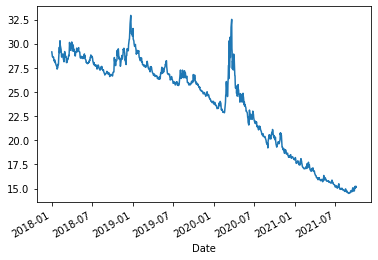

In [ ]:
selected_etf = yf.Ticker("SH")
shhist = selected_etf.history(period="max")
shhist['Close'].loc['2018-01-01':].plot()

In [ ]:
## Very high correlation between long volatility (UVXY) and short equity (SH) 
np.corrcoef(shhist['Close'].loc['2020-01-01':],vxxhist['Close'].loc['2020-01-01':])[0,1]

0.862606495929021

There are more than one kind of volatility ETFs

- VXX keep track of the S&P 500 VIX Short-Term Futures Index Total Return

- VXZ keep track of S&P 500 VIX Mid-Term Futures Index.

VXZ has a less significant contango effect than VXX, but keep track of the spot VIX less well. 

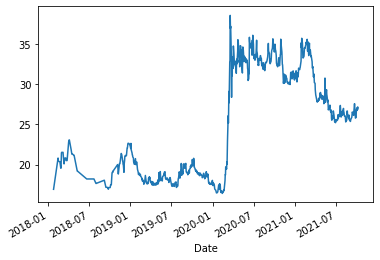

In [ ]:
selected_etf = yf.Ticker("VXZ")
vxzhist = selected_etf.history(period="max")
vxzhist['Close'].loc['2018-01-01':].plot()

In the following lectures we will introduce different strategy that aims to reduce portfolio drawdown during market drawdowns 

- Commodities Trend Following (Uncorrelated return during demand and supply shocks)
- Risk Parity (Leveraged bets on interest rates going down)
- Active Long Volatility (Time when to buy call/put options)



### Example of Market Regime model 

We will provide a very simple example of market regime model using Hidden Markov Model, which is equivalent conditioning stock returns on implied volatility (VIX).

In the industry, much more sophiscated models are used. TwoSigma builds a GMM model which classify market into four different states based on the return of 17 risk-premium factors. More details will be provided in Lecture 5 

In [ ]:
! pip install yfinance
! pip install hmmlearn

     |████████████████████████████████| 6.3 MB 31.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=d08a065c98d319cea879f6bc257d9d65be3f6204ad2cd1514d045bf0b3e0d4e3
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
from hmmlearn.hmm import GaussianHMM
import yfinance as yf
import numpy as np

selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max")
spyhist['Return'] = spyhist['Open'].pct_change()
trainrets = spyhist.loc['1996-01-01':'2017-01-01']
testrets = spyhist.loc['2018-01-01':'2022-02-25']

In [ ]:
hmm_model = GaussianHMM(
        n_components=2, covariance_type="full", n_iter=1000
    ).fit(trainrets['Return'].values.reshape(-1, 1))


In [ ]:

testrets['State'] = hmm_model.predict(testrets['Return'].values.reshape(-1, 1))
testrets['Filtered'] = testrets['State'] * testrets['Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


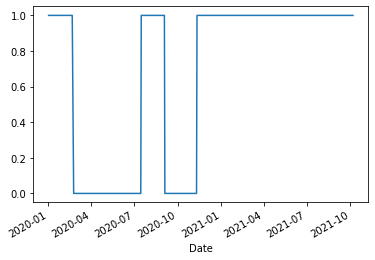

In [ ]:
testrets['State'].loc['2020-01-01':].plot()

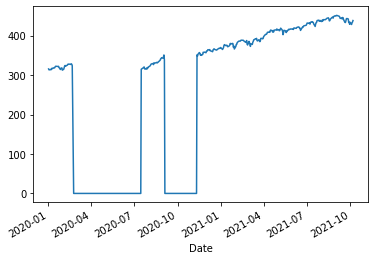

In [ ]:
testrets['Filtered'].loc['2020-01-01':].plot()

In [ ]:
## State 0 is bear market  
## State 1 is bull market 
testrets.groupby('State').mean()['Return']

State
0   -0.000540
1    0.001014
Name: Return, dtype: float64

In [ ]:
testrets.groupby('State').std()['Return']

State
0    0.021660
1    0.007312
Name: Return, dtype: float64

Can we obtain a similar model by cosidering the value of VIX? 

In [ ]:
selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max").loc['1996-01-01':'2022-01-01']
selected_etf = yf.Ticker("^VIX")
vixhist = selected_etf.history(period="max").loc['1996-01-01':'2022-01-01']
spyhist['Return'] = spyhist['Close'].pct_change()
spyhist['VIX'] = vixhist['Close']
spyhist['VIX_State'] = np.where(spyhist['VIX']<25,1,0)
trainrets = spyhist.loc['1996-01-01':'2015-01-01']
testrets = spyhist.loc['2018-01-01':'2022-01-01']

In [ ]:
testrets.groupby('VIX_State').mean()['Return']

VIX_State
0   -0.001212
1    0.001148
Name: Return, dtype: float64

In [ ]:
testrets.groupby('VIX_State').std()['Return']

VIX_State
0    0.025344
1    0.007969
Name: Return, dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


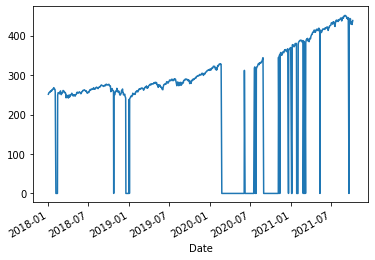

In [ ]:
testrets['Filtered'] = testrets['Close'] * testrets['VIX_State']
testrets['Filtered'].loc['2018-01-01':].plot()

Splitting the test period by the value of VIX provides a similar model as HMM. It suggests machine learning methods, applied on price data only might not outperform simple models based on econometrics. 



Changing the number of of hidden states in HMM model. The returns are clustered in three different states.

1. Low volatility states with positive return
2. Medium volatility states with near zero return
3. High volatility states with negative return 


In [ ]:
hmm_model = GaussianHMM(
        n_components=3, covariance_type="full", n_iter=1000
    ).fit(trainrets['Return'].dropna().values.reshape(-1, 1))


In [ ]:
testrets = spyhist.loc['2018-01-01':'2021-12-25']
testrets['Shifted_Return'] = testrets['Return'].shift(-1)
testrets['State'] = hmm_model.predict(testrets['Return'].values.reshape(-1, 1))
testrets['Filtered'] = testrets['State'] * testrets['Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

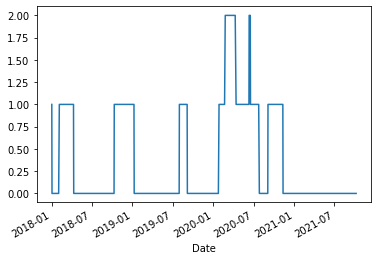

In [ ]:
testrets['State'].plot()

In [ ]:
testrets.groupby('State').mean()['Shifted_Return'] * np.sqrt(252)

State
0    0.015526
1    0.006685
2   -0.046941
Name: Shifted_Return, dtype: float64

In [ ]:
testrets.groupby('State').std()['Shifted_Return']

State
0    0.007017
1    0.014475
2    0.037721
Name: Shifted_Return, dtype: float64

In [ ]:
testrets.groupby('State').count()['Return']

State
0    645
1    266
2     38
Name: Return, dtype: int64

## Recommended readings 

- Market Regime Identification Using Hidden Markov Models https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3406068

- Regime-Switching Factor Investing with Hidden Markov Models https://www.mdpi.com/1911-8074/13/12/311/htm

- A Machine Learning Approach to Regime Modeling https://www.twosigma.com/articles/a-machine-learning-approach-to-regime-modeling/


## Lecture 3 Portfolio Optimisation 

Examples of portfolio construction 

- 60/40
- mean-variance portfolio optimisation
- Hierarchical Risk Parity (HRP) portfolio



In [1]:
! pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd

     |████████████████████████████████| 6.3 MB 30.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=3ae14d2b06778ee94faa9c2e72df92ee6959c9f220063af78971d9d765b7f8ab
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
selected_etf = yf.Ticker("TLT")
tlthist = selected_etf.history(period="max")
selected_etf = yf.Ticker("SPY")
spyhist = selected_etf.history(period="max")

In [5]:
tlthist['return'] = tlthist['Close'].loc['2008-01-01':].pct_change()
spyhist['return'] = spyhist['Close'].loc['2008-01-01':].pct_change()

In [6]:
# 60/40 portfolio 
classic = 0.6 * spyhist['return'] + 0.4 * tlthist['return']
classic = classic.dropna()

In [7]:
portfolio_classic = (1 + classic).cumprod()

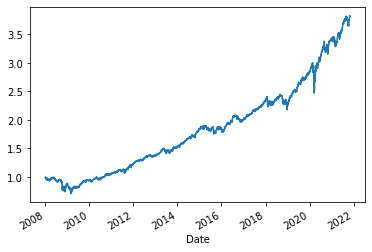

In [8]:
portfolio_classic.plot()

In [9]:
classic.mean() / classic.std() * np.sqrt(252)

0.9245891031560179

The sharpe ratio of 60/40 portfolio is better than the buy and hold portfolio and volatility-scaled portfolio of SPY. Over the last 20 years, bond is a successful hedge for stocks. 


In [10]:
! pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 7.5 MB/s 
     |████████████████████████████████| 2.7 MB 26.3 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [11]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

We will demonstrate a very basic example of Mean-variance optimization using different ETFs

ETF selection 
- SPY: US Stocks 500 (Core)
- QQQ: US Tech Stocks 100 (Growth)
- TLT: US 20Y+ Treasuries (Interest Rates)
- LQD: US Investment Grade Corp Bonds (Credit)
- GLD: Gold (Precious Metals)
- DBC: Invesco DB Commodity Index Tracking Fund (Commodities)

In [12]:
prices = list()

ETF_list = ['SPY','QQQ','TLT','LQD','GLD','DBC']

for ETF in ETF_list :
    selected_etf = yf.Ticker(ETF)
    etfhist = selected_etf.history(period="max")
    prices.append(etfhist['Close'].loc['2005-01-01':])

In [13]:
merged_prices = pd.DataFrame(pd.concat(prices,axis=1))
merged_prices.columns = ETF_list

In [14]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(merged_prices.loc['2008-01-01':])
S = CovarianceShrinkage(merged_prices).ledoit_wolf()

In [15]:
from pypfopt.efficient_frontier import EfficientFrontier

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

In [16]:
cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('SPY', 0.0),
             ('QQQ', 0.45749),
             ('TLT', 0.44285),
             ('LQD', 0.06862),
             ('GLD', 0.03103),
             ('DBC', 0.0)])

In [17]:
ef.portfolio_performance(verbose=True)

Expected annual return: 11.0%
Annual volatility: 9.8%
Sharpe Ratio: 0.92


(0.10992870637304279, 0.09809876423572154, 0.9167159961052422)

Lets use a different portfolio optimisation method, Hierarchical Risk Parity (HRP) portfolio.

Risk Parity portfolio tends to overweights bonds (LQD,TLT).

In [18]:
from pypfopt.hierarchical_portfolio import HRPOpt

In [19]:
ef = HRPOpt(merged_prices.loc['2008-01-01':].pct_change(), S)

In [20]:
ef.optimize()

OrderedDict([('DBC', 0.10269893750449827),
             ('GLD', 0.12297950895350951),
             ('LQD', 0.4933588232885059),
             ('QQQ', 0.04103637914080911),
             ('SPY', 0.04770065544405054),
             ('TLT', 0.19222569566862668)])

In [21]:
ef.portfolio_performance()

(0.06307052789657792, 0.07661976685307859, 0.5621333719165101)

We can also change the optimisation criteria for Efficiet Frontier to penalise downside volatility only. For long-only portfolios, it is often better to use Sortino Ratio which penalise downside volatility only. 

In [22]:
from pypfopt import expected_returns, EfficientSemivariance

In [23]:
mu = expected_returns.mean_historical_return(merged_prices.loc['2008-01-01':])
historical_returns = expected_returns.returns_from_prices(merged_prices.loc['2008-01-01':])

es = EfficientSemivariance(mu, historical_returns)
es.efficient_return(0.1)

OrderedDict([('SPY', 1.041758562e-07),
             ('QQQ', 0.374841807467234),
             ('TLT', 0.3877243114830036),
             ('LQD', 0.156792184811783),
             ('GLD', 0.0806414107702706),
             ('DBC', 1.810180586e-07)])

In [24]:
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

OrderedDict([('SPY', 0.0), ('QQQ', 0.37484), ('TLT', 0.38772), ('LQD', 0.15679), ('GLD', 0.08064), ('DBC', 0.0)])
Expected annual return: 10.0%
Annual semi-deviation: 6.3%
Sortino Ratio: 1.27


(0.10000006721096784, 0.0631072407333323, 1.2676844412991897)

In [25]:
target_portfolio = list()

for target_return in [0.05,0.1,0.15]:
    es = EfficientSemivariance(mu, historical_returns)
    es.efficient_return(target_return)
    weights = es.clean_weights()
    weights['Sortino'] = es.portfolio_performance()[-1]
    weights['Target'] = target_return
    target_portfolio.append(weights)

In [26]:
pd.DataFrame(target_portfolio)

,SPY,QQQ,TLT,LQD,GLD,DBC,Sortino,Target
0,0.06609,0.08094,0.24623,0.43511,0.09361,0.07801,0.806701,0.05
1,0.00000,0.37484,0.38772,0.15679,0.08064,0.00000,1.267684,0.10
2,0.00000,0.82790,0.17209,0.00000,0.00000,0.00000,1.059828,0.15


There are other portfolio optimisation methods such as Black-Litterman which can incoporate our guess on portfolio returns 


#### Volatility Scaling is what you need for portfolio optimisation

We will demonstrate a very simple but effective way to construct portfolio which can be applied to individual assets and strategies. 

We decide a lookback period (252 days) to calculate the rolling volatility of each asset. For a given risk level (15% p.a.), we scale the position we will take for each asset so that we will have equal risk in each asset, before taking into account of correlation between strategies.

We then take the simple average over these strategies to form our portfolio. 

We can then calculate the overall volatility of the portfolio, which will be lower than the given risk level due to negative correlation between strategies. We can then leverage the whole portfolio to the target risk level. 

While this method is different from risk parity, as it does not explicitly consider the correlation between assets. The two-step optimisation process is more robust than risk parity when correlation structure between stratgies/assets changes. 


In [27]:
merged_returns = merged_prices.pct_change().dropna()
merged_std = merged_returns.rolling(252).std() * np.sqrt(252)

In [28]:
merged_pos = 0.2 / merged_std 

In [29]:
merged_portfolio = merged_pos * merged_returns

In [30]:
portfolio = (1 + np.mean(merged_portfolio.loc['2008-01-01':,],axis=1)).cumprod()

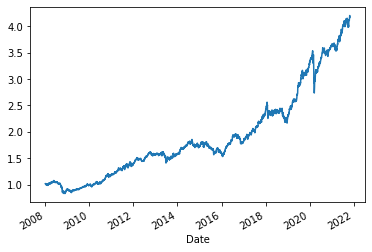

In [31]:
portfolio.plot()

In [32]:
average_return = np.mean(merged_portfolio.loc['2008-01-01':,],axis=1)

In [33]:
average_return.mean() / average_return.std() * np.sqrt(252)

0.9874273544763087

In [34]:
average_return.mean() * 252, average_return.std() * np.sqrt(252)

(0.10939505127285938, 0.11078794888245534)

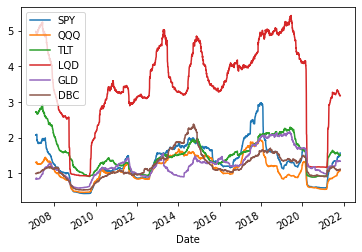

In [35]:
merged_pos.dropna().plot()

The sharpe ratio we obtained is better than the one we obtained by Mean-Variance optimisation and other optimisation methods. Our method is also more robust as it is based on simple rules. Some portfolio optimisation methods might fail to converge due to solving a non-convex problem. 

It is also better than the traditional 60/40 portfolio.

Taking a simple average of vol-scaled strategies can outperform more sophiscated portfolio optimisation methods unless one has a good understanding on the correlation structure of the strategies.

As above, we assume we can take leverage without incurring additional costs. For our example, we assume we can leverage on US Investment Crop Bonds (LQD) up to 5x, which is unlikely for retail to achieve. 







### Recent methods in portfolio optimisation 

The ETF we considered above are the building blocks of the global financial market. We have not included crypto due to its lack of history. 

Pensions funds often diversify into real estates and private equity and other illuquid assets. We will not offer an in-depth discussion here. 

Since the financial crisis, due to high fees and under-performance compared to the market, pensions funds are limiting their allocation to hedge funds. There are many hedge fund strategies, some requires sophicated market knowledge such as Merger Arbitrage and Credit Funds so we will not consider these here. 

In the following tutorials we will focus on CTA funds and long-short equity funds. As the turnover period of these strategies are often measured in days/months, it is still possible for retail to implement a crude version of these strategies, through the use of different ETFs, which we will demonstarte below. 


Many market-neutral equity funds to employ machine learning methods to build strategies and models. The data required to build a market-neutral and factor neutral fund is often not accessible to retail investors. Numerai allows retail traders to build their own market-neutral equity strategies with all the data and infrastructure provided. 


While the strategies themselves can be based on both momentum and mean-reversion, machine learning models works well when correlation is stationary. When there are shocks in the market, machine learning models in general will perform poorly. We suggest during market stress, trend following and other long volatility strategies would act as a good diversifier for machine learning based strategies. 


In the later lectures, we will explore how to include long volatility strategies as part of the portfolio to achieve long term growth. These ideas are suggested by Christopher Cole (Artemis Capital Management) and Mutiny Funds. Most of the time these strategies are only available for professional investors.



An example allocation for retail investors 

- 50% Equity Index Fund
- 15% Commodities/ETF Trend Following 
- 15% Machine-Learning based Market Neutral Fund (Numerai)
- 20% Defensive Assets (Cash/Government Bonds/Gold)



## Recommended Readings 


- The Allegory of the Hawk and Serpent https://www.artemiscm.com/research-market-views
- The Cockroach Fund https://mutinyfund.com/cockroach/  
- Numerai https://numer.ai/


## Lecture 4 Technical Analysis

Technical analysis refers to the use of price data to predict future returns.

Under efficient Market Theory Hypothesis, it is impossible to use technical analysis to outperform the market. However, systematic trend following has achieved outsizing returns during 1980s. 

In factor models (to be introduced in Lecture 5), we often consider style factors which refers to selecting assets based on certain known price and fundamentals based attributes. 

For price-based style factors, mean-reversion and momentum are often considered. 

Mean-reversion relies on the assumption that market over-reacts on news and shocks. Therefore, it is portfitable to buy the underperformers and sell them after they recover. 


Mean-reversion can generate alpha because they often take on liquidity risk (Example: Buying EM credit after some geo-political events). 
Another reason is due to positioning effect, liquidations of hedge funds can often result in high quality assets being sold at a discount. Mean-reversion take advantage of the temporary imbalance of order flow. 
Another example would be retail traders being forced out as stop losses are hit. 

The mantra of buy-the-dip is a form of mean-reversion which is implicitly supported by the FED. 

Momentum can generate profits because of investor's herding behaviour. Market participants have a tendency to chase winners, such as Tesla. For stocks that have an important weight in the index, a positive reinforcement loop can result as the stock price increases, its weighting increases, resulting a buying demand from passive investing funds. 

Momentum can also be consider as a way of avoiding losers. When share price drops continuously, it is often the case where the company or the industry is getting out of favour (Example: High-Street retail). A downward spiral will result as the financial conditions will get worse (Bonds will get downgraded when company cannot make a profit for a few years), which makes recovery even more difficult. 


For stocks, we often consider cross-sectional momentum, where we buy stocks that have best performance in the last year and sell stocks that have the worst performance in the last year. We can also rank momentum within each sector and industry to eliminate market risk. 













### Moving Averages Crossover 

We will use Moving Averages Crossover, which is a very simple trend following strategy.

The stratgy requires the input of two parameters. A short term lookback and long term lookback. We compute the moving average of price based on these two lookback periods. We long the asset when the short-term MA is greater than the long-term MA and short the asset when the short-term MA fallers below the long-term MA. 

How to make a robust trend following strategy
- Increase the number of assets traded
- Use different lookback periods to capture both short and long term trends
- Use different entry and exit rules
- Scale asset returns by volatility if leverage can be used
- Consider to be long-only as it is more difficult to profit from down trends, especially for equities. 


In [36]:
import pandas as pd

In [37]:
prices = list()

ETF_list = ['SPY','TLT','GLD','SLV','DBC','UUP']

for ETF in ETF_list :
    selected_etf = yf.Ticker(ETF)
    etfhist = selected_etf.history(period="max")
    etfhist['Return'] = etfhist['Open'].pct_change()
    prices.append(etfhist['Return'])

In [38]:
merged_prices = pd.DataFrame(pd.concat(prices,axis=1)).dropna()
merged_prices.columns = ETF_list

In [39]:
def Moving_Average(merged_prices,ticker='DBC',fast=5,slow=50,long_only=True,):
  stock = pd.DataFrame(merged_prices[ticker])
  stock['Shifted_Return'] = stock[ticker].shift(-1)
  stock['Price'] = (1+stock[ticker]).cumprod()
  stock['MA_{}'.format(fast)] = stock['Price'].rolling(fast).mean()
  stock['MA_{}'.format(slow)] = stock['Price'].rolling(slow).mean()
  if long_only:
    stock['Portfolio_return'] = np.where(stock['MA_{}'.format(slow)]<stock['MA_{}'.format(fast)],1,0) * stock['Shifted_Return']
  else:
    stock['Portfolio_return'] = np.where(stock['MA_{}'.format(slow)]<stock['MA_{}'.format(fast)],1,-1) * stock['Shifted_Return']   
  return stock

Example of trend following strategies applied on Commodity ETF (DBC)

Trend Following improves significantly the sharpe ratio compared to buy-and-hold. 

In [40]:
stock = Moving_Average(merged_prices,ticker='DBC',fast=5,slow=50,long_only=False)

In [41]:
stock['Portfolio_return'].loc['2005-01-01':].mean() / stock['Portfolio_return'].loc['2005-01-01':].std() * np.sqrt(252)

0.6455891354612034

In [42]:
stock['Shifted_Return'].loc['2005-01-01':].mean() / stock['Shifted_Return'].loc['2005-01-01':].std() * np.sqrt(252)

0.071110357083655

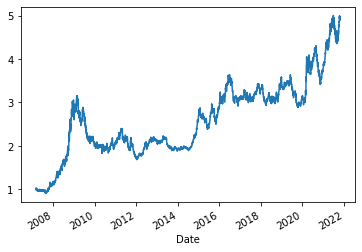

In [43]:
(1+stock['Portfolio_return'].loc['2005-01-01':]).cumprod().plot()

In [ ]:
stock['Portfolio_return'].loc['2005-01-01':].describe()

count    3688.000000
mean        0.000512
std         0.012500
min        -0.071038
25%        -0.006050
50%         0.000616
75%         0.006976
max         0.095899
Name: Portfolio_return, dtype: float64

In [ ]:
stock['Portfolio_return'].loc['2005-01-01':].skew()

0.17922674648426398

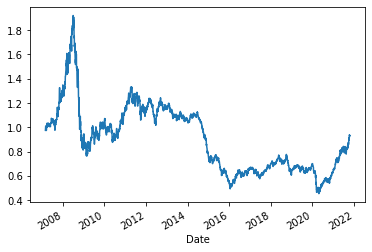

In [ ]:
(1+stock['Shifted_Return'].loc['2005-01-01':]).cumprod().plot()

In [ ]:
stock['Shifted_Return'].loc['2015-01-01':].skew()

-0.6394880636658302

In [ ]:
stock['Shifted_Return'].loc['2005-01-01':].describe()

count    3688.000000
mean        0.000059
std         0.012510
min        -0.095899
25%        -0.006291
50%         0.000520
75%         0.006699
max         0.073128
Name: Shifted_Return, dtype: float64

### Statistical property of trend following strategy

Compare the distribution of daily returns of the underlying asset and the trend following version, we conclude trend following improves the skewness of the strategy. 

We then compute the rolling 1 year return of both the underlying asset and the trend following strategy. The scatterplot shows a payoff similar to a long straddle. This is why trend following can be considered as a long volatility strategy. 




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


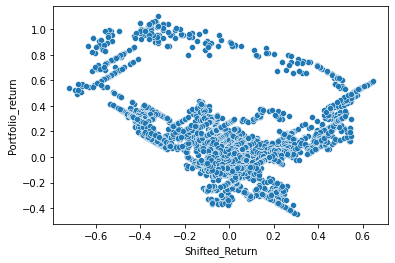

In [44]:
import seaborn as sns
sns.scatterplot(stock['Shifted_Return'].rolling(252).mean() * 252,stock['Portfolio_return'].rolling(252).mean()* 252)

### Some reasons why technical analysis works 

Technical analysis are often used by retail and professionals in making trade decisions. Due to positioning of market participants, a self-reinforeced feedback loop is created when price follows a certain pattern.

Here, we argue positioning, rather than psychology is the main driver of success for technical analysis. While it is important to analyse market sentiment, from the vast amount of news and social media data generated, sentiment only has an impact on the price after someone decides to take a trade follow/against it. 


Not all kinds of technical analysis are equally useful, candlestick patterns or some really fancy indicators would not be relevant. 

Widely used indicators for trends and mean-reversion would have predictive value due to their use in both strategy and risk management process. For example, market participants will often reduce position size of a long position when prices fall below 200 day moving averages. 




Recommendations from Krishnan (Krishnan 2021)
- Take key support and resistance levels seriously, but verify where they are on your own
- Build your own trend following, volatility control and risk parity models. Calibrate them to track the performance of individual
funds or benchmark indices. Pay particular attention to levels where the model signal changes from BUY to SELL, or vice versa. These are your key levels.
- Check the options markets in the assets you trade for large open interest at specific strikes. Infer whether dealers are likely to be long or short. When dealers are short, expect volatility expansion in a wide range around the strike.









#### How to obtain data for market positioning 

For Commodities Futures, Trading Commission Reports would be a useful indicator for long term price movements as it provides an overview of how hedge funds and other market participants trade at a lag. 
https://data.nasdaq.com/data/CFTC-commodity-futures-trading-commission-reports 

For stocks that can be shorted and has options, short interest, borrowing rate and put-call ratios can be used. These data can often be obtained with little lag compared to other regulatory filings. There is also a concept of Gamma Exposure Index (GEX) which aims to the hedging activity of option market-makers based on the current stock price.


Insiders and hedge funds with significant holdings need to disclose when they enter trades for stocks. Hedge funds are also required to their holdings each quarter. For US stocks, SEC filings (SEC Form 4, 13F Filings) provided the required data.  

There are academic papers suggesting following insiders and hedge funds can generate excess return. In particular, we can extend the definition of insiders to politicians who often has private information and the power to change economic policies. 




## Recommended Reading

- Market Tremors: Quantifying Structural Risks in Modern Financial Markets (Ash Bennington and Hari P. Krishnan 2021)
- Understanding the Momentum Risk Premium: An In-Depth Journey Through
Trend-Following Strategies https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3042173
